# **任务描述：**

### 本次实践是一个多分类任务，需要将照片中的宝石分别进行识别，完成**宝石的识别**

### **实践平台：百度AI实训平台-AI Studio、PaddlePaddle2.0.0 动态图**
### 要求：使用CNN方法实现宝石识别！

（1）补充空白代码，包含网络结构设计

（2）调节网络结构设计、调节参数设置，主要调整训练轮次epoch，和learning_strategy相关参数，根据训练loss与准确率，观测模型性能

（3）学有余力同学，可以在训练阶段，若干轮次epoch（可以自行设定）进行一次验证，随时观测验证集上效果，并把验证集上的loss与acc画成图，根据此可以观测模型是否有过拟合。

![](https://ai-studio-static-online.cdn.bcebos.com/7640d4434f894f5dbae1d85c62e54b8476e24856aabc4c5f9915fea1b26f3ebc)


# 卷积神经网络
### **卷积神经网络是提取图像特征的经典网络，其结构一般包含多个卷积层与池化层的交替组合。**
![](https://ai-studio-static-online.cdn.bcebos.com/5099df2494f144e4b11b49b02b4c113c0507700115504cf98b9a972fd2393d75)



# 数据集介绍

* **数据集文件名为archive_train.zip,archive_test.zip。**

* **该数据集包含25个类别不同宝石的图像。**

* **这些类别已经分为训练和测试数据。**

* **图像大小不一，格式为.jpeg。**


![](https://ai-studio-static-online.cdn.bcebos.com/7640d4434f894f5dbae1d85c62e54b8476e24856aabc4c5f9915fea1b26f3ebc)


In [2]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
# !ls /home/aistudio/data

: 

: 

In [ ]:
#导入需要的包
import os
import zipfile
import random
import json
import cv2
import numpy as np
import paddle.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import paddle
from paddle.io import Dataset
import paddle.nn as nn 

print(paddle.__version__)

2.4.2


: 

: 

In [ ]:
# paddle.utils.run_check()

: 

: 

# 1、数据准备

In [ ]:
num_classes = 25
##########################################################
# 调整的参数
picture_size = 224
epoch_test = 100
batch_size_test = 64
learn_rate_tes = 0.004

'''
参数配置
'''
train_parameters = {
    "input_size": [3, 224, 224],                     # 输入图片的shape
    "class_dim": 25,                                 # 分类数
    "src_path":"./archive_train.zip",   # 原始数据集路径
    "target_path":"/home/asus/文档/GitHub/MyPythonProject/CNN学习/AlexNet-Pytorch/data/dataset",     # 要解压的路径 
    "train_list_path": "./train.txt",                # train_data.txt路径
    "eval_list_path": "./eval.txt",                  # eval_data.txt路径
    "label_dict":{},                                 # 标签字典
    "num_epochs":epoch_test,                                 # 训练轮数
    "train_batch_size": batch_size_test,                          # 批次的大小
    "learning_strategy": {                           # 优化函数相关的配置
        "lr": learn_rate_tes                                  # 超参数学习率
    } 
}


: 

: 

In [ ]:
def unzip_data(src_path,target_path):
    '''
    解压原始数据集，将src_path路径下的zip包解压至data/dataset目录下
    ''' 
    if(not os.path.isdir(target_path)):    
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()
    else:
        print("文件已解压")

: 

: 

In [ ]:
def get_data_list(target_path,train_list_path,eval_list_path):
    '''
    生成数据列表
    '''
    # 获取所有类别保存的文件夹名称
    data_list_path=target_path
    class_dirs = os.listdir(data_list_path) 
    if '__MACOSX' in class_dirs:
        class_dirs.remove('__MACOSX')
    # 存储要写进eval.txt和train.txt中的内容
    trainer_list=[]
    eval_list=[]
    class_label=0
    i = 0
    
    for class_dir in class_dirs:   
        path = os.path.join(data_list_path,class_dir)
        # 获取所有图片
        img_paths = os.listdir(path)
        for img_path in img_paths:                                        # 遍历文件夹下的每个图片
            i += 1
            name_path = os.path.join(path,img_path)                       # 每张图片的路径
            if i % 10 == 0:                                                
                eval_list.append(name_path + "\t%d" % class_label + "\n")
            else: 
                trainer_list.append(name_path + "\t%d" % class_label + "\n") 
        
        train_parameters['label_dict'][str(class_label)]=class_dir
        class_label += 1
            
    #乱序  验证集
    random.shuffle(eval_list)
    with open(eval_list_path, 'a') as f:
        for eval_image in eval_list:
            f.write(eval_image) 
            
    #乱序训练集【补充代码】       
    random.shuffle(trainer_list)
    with open(train_list_path, 'a') as f:
        for trainer_image in trainer_list:
            f.write(trainer_image) 


    print ('生成数据列表完成！')

: 

: 

In [ ]:
# 参数初始化
src_path=train_parameters['src_path']
target_path=train_parameters['target_path']
train_list_path=train_parameters['train_list_path']
eval_list_path=train_parameters['eval_list_path']
batch_size=train_parameters['train_batch_size']

# 解压原始数据到指定路径
unzip_data(src_path,target_path)

#每次生成数据列表前，首先清空train.txt和eval.txt
with open(train_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
with open(eval_list_path, 'w') as f: 
    f.seek(0)
    f.truncate() 
    
#生成数据列表   
get_data_list(target_path,train_list_path,eval_list_path)

文件已解压
生成数据列表完成！


: 

: 

In [ ]:
class Reader(Dataset):
    def __init__(self, data_path, mode='train'):
        """
        数据读取器
        :param data_path: 数据集所在路径
        :param mode: train or eval
        """
        super().__init__()
        self.data_path = data_path
        self.img_paths = []
        self.labels = []

        if mode == 'train':
            with open(os.path.join(self.data_path, "train.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))

        else:
            with open(os.path.join(self.data_path, "eval.txt"), "r", encoding="utf-8") as f:
                self.info = f.readlines()
            for img_info in self.info:
                img_path, label = img_info.strip().split('\t')
                self.img_paths.append(img_path)
                self.labels.append(int(label))


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        # 第一步打开图像文件并获取label值
        img_path = self.img_paths[index]
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB') 

        img = img.resize((picture_size,picture_size), Image.BILINEAR)
        img = np.array(img).astype('float32')
        img = img.transpose((2, 0, 1)) / 255
        label = self.labels[index]
        label = np.array([label], dtype="int64")
        return img, label

    def print_sample(self, index: int = 0):
        print("文件名", self.img_paths[index], "\t标签值", self.labels[index])

    def __len__(self):
        return len(self.img_paths)

: 

: 

In [ ]:
#训练数据加载
train_dataset = Reader('./',mode='train')
train_loader = paddle.io.DataLoader(train_dataset, batch_size=16, shuffle=True)

#测试数据加载
eval_dataset = Reader('./',mode='eval')
eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)

: 

: 

In [ ]:
train_dataset.print_sample(200)
print(train_dataset.__len__())

eval_dataset.print_sample(0)
print(eval_dataset.__len__())

print(eval_dataset.__getitem__(10)[0].shape)
print(eval_dataset.__getitem__(10)[1].shape)

文件名 /home/asus/文档/GitHub/MyPythonProject/CNN学习/AlexNet-Pytorch/data/dataset/Labradorite/labradorite_20.jpg 	标签值 3
730
文件名 /home/asus/文档/GitHub/MyPythonProject/CNN学习/AlexNet-Pytorch/data/dataset/Rhodochrosite/rhodochrosite_1.jpg 	标签值 17
81
(3, 224, 224)
(1,)


: 

: 

In [ ]:
Batch=0
Batchs=[]
all_train_accs=[]

def draw_train_acc(Batchs, train_accs):
    title="training accs"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("acc", fontsize=14)
    plt.plot(Batchs, train_accs, color='green', label='training accs')
    plt.legend()
    plt.grid()
    plt.show()

all_train_loss=[]
def draw_train_loss(Batchs, train_loss):
    title="training loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.legend()
    plt.grid()
    plt.show()

: 

: 

# 2、定义模型

In [ ]:
"""
卷积神将网络的计算公式为：
N=(W-F+2P)/S+1
其中
N：输出大小
W：输入大小
F：卷积核大小
P：填充值的大小
S：步长大小
"""

'\n卷积神将网络的计算公式为：\nN=(W-F+2P)/S+1\n其中\nN：输出大小\nW：输入大小\nF：卷积核大小\nP：填充值的大小\nS：步长大小\n'

: 

: 

In [ ]:
# 输入图像大小为224*224 ———— picture size

class MyLeNet5(paddle.nn.Layer):
    def __init__(self):
        super().__init__()
        
        # 3 个通道输入，32个通道输出 ———— 224 - 3 / 1 + 1 = 222
        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=32, kernel_size=(3, 3))
        # 222 - 2 / 2 + 1  = 111
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        # 32个通道输入，64个通道输出  ———— 111 - 3  + 1 = 109
        self.conv2 = paddle.nn.Conv2D(in_channels=32, out_channels=64, kernel_size=(3,3))
        # 109 - 2/2 + 1 = 54
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)

        # 54 - 3 /1 + 1 = 52
        self.conv3 = paddle.nn.Conv2D(in_channels=64, out_channels=64, kernel_size=(3,3))

        self.flatten = paddle.nn.Flatten()

        # 64 * 52 * 52 = 173056
        self.linear1 = paddle.nn.Linear(in_features=173056, out_features=1024)
        self.linear2 = paddle.nn.Linear(in_features=1024, out_features=25)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.flatten(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


: 

: 

In [ ]:
class MyAlexNet(paddle.nn.Layer):
    def __init__(self):
        super().__init__()
        self.features=nn.Sequential(
            # 224 - 11 +1 = 214
            nn.Conv2D(3,48, kernel_size=11),
            nn.ReLU(),
            # 214 - 3 / 2 + 1 = 106
            nn.MaxPool2D(kernel_size=3,stride=2),

            # 105 - 5 + 2*2  + 1  = 105
            nn.Conv2D(48,128, kernel_size=5, padding=2),
            nn.ReLU(),
            # 105 -3 /2 +1 = 52
            nn.MaxPool2D(kernel_size=3,stride=2),

            # 52 - 3 + 2 +1 = 52
            nn.Conv2D(128,192,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),

            # 52 - 3 + 2 + 1 = 52
            nn.Conv2D(192,192,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),

            # 52 - 3 +2 +1 = 52
            nn.Conv2D(192,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),

            # 52 -3 /2 +1 = 25
            nn.MaxPool2D(kernel_size=3,stride=2),
        )
        self.classifier=nn.Sequential(
            # 128 * 25 * 25 = 80000
            nn.Linear(80000,2048),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(2048,2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048,25),
        )
 
 
    def forward(self,x):
        x=self.features(x)
        """
        torch  ———— torch.flatten(input, start_dim=0, end_dim=-1)
        paddle ———— paddle.nn.Flatten(start_axis=1, stop_axis=- 1)
        """
        flatten = paddle.nn.Flatten(start_axis=1, stop_axis=-1)
        x=flatten(x)
        x=self.classifier(x)
 
        return x

: 

: 

In [ ]:
class MyVGG16(paddle.nn.Layer):
    def __init__(self):
        super(MyVGG16, self).__init__()
        # 特征提取层
        self.features = nn.Sequential(
            # 224 - 3 +2  +1 = 224
            nn.Conv2D(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1),
            # 224 - 3 +2 +1 = 224
            nn.Conv2D(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1),
            # 224 -2 /2 + 1 = 112
            nn.MaxPool2D(kernel_size=2,stride=2),
            
            # 112 -3 + 2 +1 = 112
            nn.Conv2D(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.Conv2D(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            # 112 -2 /2 +1 = 56
            nn.MaxPool2D(kernel_size=2, stride=2),
            
            # 56 - 3 +2 +1 = 56
            nn.Conv2D(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.Conv2D(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.Conv2D(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            # 56 - 2 / 2 +1 = 28
            nn.MaxPool2D(kernel_size=2,stride=2),

            # 28 -3 +2 +1 = 28
            nn.Conv2D(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.Conv2D(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.Conv2D(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            # 28 -2 /2 +1 = 14
            nn.MaxPool2D(kernel_size=2, stride=2),

            # 14 -3 +2 +1 = 14
            nn.Conv2D(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.Conv2D(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.Conv2D(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            # 14 -2 /2 +1 =7
            nn.MaxPool2D(kernel_size=2, stride=2),
        )

        # 分类层
        self.classifier = nn.Sequential(
            nn.Linear(in_features=7*7*512,out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096,out_features=25)
        )

    def forward(self,x):
        x = self.features(x)
        flatten = paddle.nn.Flatten(start_axis=1, stop_axis=-1)
        x=flatten(x)
        result = self.classifier(x)
        return result

: 

: 

In [ ]:
class MyGoogLeNet(paddle.nn.Layer):
    def __init__(self, num_classes=25, aux_logits=True, init_weights=False):
        super(MyGoogLeNet, self).__init__()
        self.aux_logits = aux_logits

        self.conv1 = BasicConv2D(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2D(3, stride=2, ceil_mode=True)

        self.conv2 = BasicConv2D(64, 64, kernel_size=1)
        self.conv3 = BasicConv2D(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2D(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2D(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2D(3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2D((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        flatten = paddle.nn.Flatten(start_axis=1, stop_axis=-1)
        x=flatten(x)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.training and self.aux_logits:   # eval model lose this layer
            return x, aux2, aux1
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2D):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

#inception结构
class Inception(paddle.nn.Layer):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2D(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2D(in_channels, ch3x3red, kernel_size=1),
            BasicConv2D(ch3x3red, ch3x3, kernel_size=3, padding=1)   # 保证输出大小等于输入大小
        )

        self.branch3 = nn.Sequential(
            BasicConv2D(in_channels, ch5x5red, kernel_size=1),
            BasicConv2D(ch5x5red, ch5x5, kernel_size=5, padding=2)   # 保证输出大小等于输入大小
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2D(kernel_size=3, stride=1, padding=1),
            BasicConv2D(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        # return torch.cat(outputs, 1)
        return paddle.concat(outputs, axis=1)

#辅助分类器
class InceptionAux(paddle.nn.Layer):
    def __init__(self, in_channels, num_classes = 25):
        super(InceptionAux, self).__init__()
        self.averagePool = nn.AvgPool2D(kernel_size=5, stride=3)
        self.conv = BasicConv2D(in_channels, 128, kernel_size=1)  # output[batch, 128, 4, 4]

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        flatten = paddle.nn.Flatten(start_axis=1, stop_axis=-1)
        x=flatten(x)

        x = F.dropout(x, 0.5, training=self.training)
        # N x 2048
        x = F.relu(self.fc1(x))
        x = F.dropout(x, 0.5, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x


class BasicConv2D(paddle.nn.Layer):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2D, self).__init__()
        self.conv = nn.Conv2D(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x


: 

: 

In [ ]:
class BasicBlock(nn.Layer):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2D

        if dilation > 1:
            raise NotImplementedError(
                "Dilation > 1 not supported in BasicBlock"
            )

        self.conv1 = nn.Conv2D(
            inplanes, planes, 3, padding=1, stride=stride, bias_attr=False
        )
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2D(planes, planes, 3, padding=1, bias_attr=False)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class BottleneckBlock(nn.Layer):
    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        base_width=64,
        dilation=1,
        norm_layer=None,
    ):
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2D
        width = int(planes * (base_width / 64.0)) * groups

        self.conv1 = nn.Conv2D(inplanes, width, 1, bias_attr=False)
        self.bn1 = norm_layer(width)

        self.conv2 = nn.Conv2D(
            width,
            width,
            3,
            padding=dilation,
            stride=stride,
            groups=groups,
            dilation=dilation,
            bias_attr=False,
        )
        self.bn2 = norm_layer(width)

        self.conv3 = nn.Conv2D(
            width, planes * self.expansion, 1, bias_attr=False
        )
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU()
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class MyResNet(nn.Layer):
    def __init__(
        self,
        block,
        depth=50,
        width=64,
        num_classes=1000,
        with_pool=True,
        groups=1,
    ):
        super().__init__()
        layer_cfg = {
            18: [2, 2, 2, 2],
            34: [3, 4, 6, 3],
            50: [3, 4, 6, 3],
            101: [3, 4, 23, 3],
            152: [3, 8, 36, 3],
        }
        layers = layer_cfg[depth]
        self.groups = groups
        self.base_width = width
        self.num_classes = num_classes
        self.with_pool = with_pool
        self._norm_layer = nn.BatchNorm2D

        self.inplanes = 64
        self.dilation = 1

        self.conv1 = nn.Conv2D(
            3,
            self.inplanes,
            kernel_size=7,
            stride=2,
            padding=3,
            bias_attr=False,
        )
        self.bn1 = self._norm_layer(self.inplanes)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2D(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        if with_pool:
            self.avgpool = nn.AdaptiveAvgPool2D((1, 1))

        if num_classes > 0:
            self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2D(
                    self.inplanes,
                    planes * block.expansion,
                    1,
                    stride=stride,
                    bias_attr=False,
                ),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.with_pool:
            x = self.avgpool(x)

        if self.num_classes > 0:
            x = paddle.flatten(x, 1)
            x = self.fc(x)

        return x


def _resnet(arch, Block, depth, pretrained, **kwargs):
    model = MyResNet(Block, depth, **kwargs)
    if pretrained:
        assert (
            arch in model_urls
        ), f"{arch} model do not have a pretrained model now, you should set pretrained=False"
        weight_path = get_weights_path_from_url(
            model_urls[arch][0], model_urls[arch][1]
        )

        param = paddle.load(weight_path)
        model.set_dict(param)

    return model


def MyResNet18(pretrained=False, **kwargs):
    return _resnet('resnet18', BasicBlock, 18, pretrained, **kwargs)


def MyResNet50(pretrained=False, **kwargs):
    return _resnet('resnet50', BottleneckBlock, 50, pretrained, **kwargs)


def MyResNet101(pretrained=False, **kwargs):
    return _resnet('resnet101', BottleneckBlock, 101, pretrained, **kwargs)


def MyResNet152(pretrained=False, **kwargs):
    return _resnet('resnet152', BottleneckBlock, 152, pretrained, **kwargs)

: 

: 

In [ ]:
# BN+ReLU+1x1 Conv+BN+ReLU+3x3 Conv结构，最后也加入dropout层以用于训练过程。
class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        # 3*224*224
        self.add_sublayer("norm1", nn.BatchNorm2D(num_input_features))
        # paddle的框架会自动进行inplace的操作，不需要用户进行额外的设置
        # 故inplace=True无法设置，也不必要设置
        self.add_sublayer("relu1", nn.ReLU())
        # 本次卷积不影响尺寸大小 224*224
        self.add_sublayer("conv1", nn.Conv2D(num_input_features, bn_size*growth_rate,
                                           kernel_size=1, stride=1,bias_attr=False))
        self.add_sublayer("norm2", nn.BatchNorm2D(bn_size*growth_rate))
        self.add_sublayer("relu2", nn.ReLU())
        # 本次卷积不影响尺寸大小 224*224
        self.add_sublayer("conv2", nn.Conv2D(bn_size*growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,bias_attr=False))
        self.drop_rate = drop_rate

    def forward(self, x):
        # print(x.size())
        new_features = super(_DenseLayer, self).forward(x)
        # print(new_features.size())
        if self.drop_rate > 0:
            # 因此在调用F.dropout()时，直接将self.training传入函数，就可以在训练时应用dropout，评估时关闭dropout。
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        # print(torch.cat([x, new_features], 1).size())
        # 拼接第二维度
        return paddle.concat([x, new_features], 1)

class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            # 根据上一个模块可知，每一个输出的特征数都是累加growth_rate
            # 如3，7，11的growth_rate在第3层时，包含了7（x）+4（第三次的growth_rate）
            # 此时的7又分为第一层的3（第一层）+4（第二层的growth_rate）
            # 相当于第三层连接了1，2层的输入，以此类推实现稠密链接
            layer = _DenseLayer(num_input_features+i*growth_rate, growth_rate, bn_size,
                                drop_rate)
            self.add_sublayer("denselayer%d" % (i+1,), layer)

class _Transition(nn.Sequential):
    def __init__(self, num_input_feature, num_output_features):
        super(_Transition, self).__init__()
        # 这里假设输入大小为224
        self.add_sublayer("norm", nn.BatchNorm2D(num_input_feature))
        self.add_sublayer("relu", nn.ReLU())
        # 不改变大小224
        self.add_sublayer("conv", nn.Conv2D(num_input_feature, num_output_features,
                                          kernel_size=1, stride=1,bias_attr=False))
        # 112*112
        self.add_sublayer("pool", nn.AvgPool2D(2, stride=2))

class MyDenseNet(nn.Layer):
    "DenseNet-BC model"
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64,
                 bn_size=4, compression_rate=0.5, drop_rate=0, num_classes=1000):
        super(MyDenseNet, self).__init__()

        # first Conv2d
        self.features = nn.Sequential(
            # 224
            ("conv0", nn.Conv2D(3, num_init_features, kernel_size=7, stride=2, padding=3, bias_attr=False)),
            # (224-7+6)/2+1=111.5+1=112
            ("norm0", nn.BatchNorm2D(num_init_features)),
            ("relu0", nn.ReLU()),
            # (112-3+2)/2+1=55.5+1=56
            ("pool0", nn.MaxPool2D(3, stride=2, padding=1))
        )

        # DenseBlock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            # num_layers分别为6, 12, 24, 16
            # 指一个block中的稠密链接层数
            block = _DenseBlock(num_layers, num_features, bn_size, growth_rate, drop_rate)
            self.features.add_sublayer("denseblock%d" % (i + 1), block)

            # 给到下一个block中的稠密链接层数
            num_features += num_layers*growth_rate

            if i != len(block_config) - 1:
                # compression_rate控制输出层数
                transition = _Transition(num_features, int(num_features*compression_rate))
                # 这里尺寸大小减半4次
                # 112->56->28->14->7
                self.features.add_sublayer("transition%d" % (i + 1), transition)
                # 更新下一个block的稠密链接层数
                num_features = int(num_features * compression_rate)

        # final bn+ReLU
        self.features.add_sublayer("norm5", nn.BatchNorm2D(num_features))
        self.features.add_sublayer("relu5", nn.ReLU())

        # classification layer
        # 这里经过了下面的一个平均池化 已经变成了尺寸1*1的了
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.features(x)
        features=F.avg_pool2d(features, 7, stride=1)
        out = paddle.reshape(features,[features.shape[0], -1])
        out = self.classifier(out)
        return out

: 

: 

# 3、训练模型-CNN

In [ ]:
model = ['MyLeNet5','MyAlexNet','MyVGG16','MyGoogLeNet','MyResNet18','MyResNet50','MyResNet152','MyDenseNet']

: 

: 

In [ ]:
# 把下面要修改的四个函数名的地方改为使用参数调用
function_name = 'MyAlexNet'

model = eval(function_name + '()') # 模型实例化
model.train() # 训练模式
cross_entropy = paddle.nn.CrossEntropyLoss()
opt=paddle.optimizer.SGD(learning_rate=train_parameters['learning_strategy']['lr'],\
                                                    parameters=model.parameters())


epochs_num=train_parameters['num_epochs'] #迭代次数
epochs_num = 5
for pass_num in range(train_parameters['num_epochs']):
    for batch_id,data in enumerate(train_loader()):
        image = data[0]
        label = data[1]
        # 如果是googlenet用第二行代码，虽然tensor结构中有shape参数，但是后续代码依然无法访问
        # 报错 ： 'tuple' object has no attribute 'shape'
        if function_name == 'MyGoogLeNet' or function_name == 'MyResNet34' or function_name == 'MyResNet101':
            print("是 googlenet 或者 resnet")
            predict = model(image)[0] #数据传入model
        else:
            predict = model(image)

        # print(type(predict))
        # print()
        # print(type(label))
        # print(predict)

        loss=cross_entropy(predict,label)
        acc=paddle.metric.accuracy(predict,label)#计算精度
        if batch_id!=0 and batch_id%5==0:
            Batch = Batch+5 
            Batchs.append(Batch)
            all_train_loss.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0]) 
            print("epoch:{},step:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,loss.numpy(),acc.numpy()))        
        loss.backward()       
        opt.step()
        opt.clear_grad()   #opt.clear_grad()来重置梯度
    
paddle.save(model.state_dict(),function_name)#保存模型
draw_train_acc(Batchs,all_train_accs)
draw_train_loss(Batchs,all_train_loss)

: 

: 

: 

# 4、模型评估-CNN

In [ ]:
#模型评估
para_state_dict = paddle.load(function_name) 
model = eval(function_name + '()')
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #验证模式

accs = []

for batch_id,data in enumerate(eval_loader()):#测试集
    image=data[0]
    label=data[1]     
    predict=model(image)       
    acc=paddle.metric.accuracy(predict,label)
    accs.append(acc.numpy()[0])
avg_acc = np.mean(accs)
print("当前模型在验证集上的准确率为:",avg_acc)

当前模型在验证集上的准确率为: 0.8181818


: 

: 

# 5、模型预测-CNN

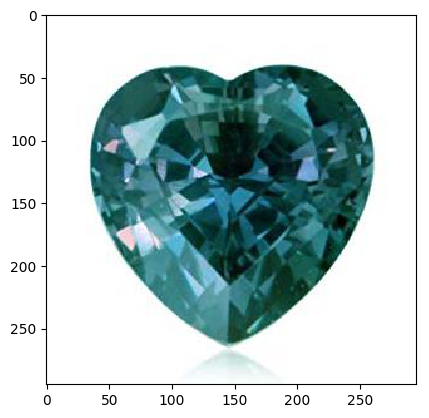

第1个样本,被预测为：Onyx Black,真实标签为：alexandrite
结束


: 

: 

In [ ]:
def unzip_infer_data(src_path,target_path):
    '''
    解压预测数据集
    '''
    if(not os.path.isdir(target_path)):     
        z = zipfile.ZipFile(src_path, 'r')
        z.extractall(path=target_path)
        z.close()


def load_image(img_path):
    '''
    预测图片预处理
    '''
    img = Image.open(img_path) 
    if img.mode != 'RGB': 
        img = img.convert('RGB') 

    ############################## 更改图片大小
    img = img.resize((picture_size, picture_size), Image.BILINEAR)
    img = np.array(img).astype('float32') 
    img = img.transpose((2, 0, 1))  # HWC to CHW 
    img = img/255                # 像素值归一化 
    return img


infer_src_path = '/home/aistudio/data/data55032/archive_test.zip'
infer_dst_path = '/home/aistudio/data/archive_test'
unzip_infer_data(infer_src_path,infer_dst_path)

para_state_dict = paddle.load("MyLeNet5")
model = MyLeNet5()
model.set_state_dict(para_state_dict) #加载模型参数
model.eval() #验证模式

#展示预测图片
infer_path='data/archive_test/alexandrite_3.jpg'
img = Image.open(infer_path)
plt.imshow(img)          #根据数组绘制图像
plt.show()               #显示图像
#对预测图片进行预处理
infer_imgs = []
infer_imgs.append(load_image(infer_path))
infer_imgs = np.array(infer_imgs)
label_dic = train_parameters['label_dict']
for i in range(len(infer_imgs)):
    data = infer_imgs[i]
    dy_x_data = np.array(data).astype('float32')
    dy_x_data=dy_x_data[np.newaxis,:, : ,:]
    img = paddle.to_tensor (dy_x_data)
    out = model(img)
    lab = np.argmax(out.numpy())  #argmax():返回最大数的索引
    print("第{}个样本,被预测为：{},真实标签为：{}".format(i+1,label_dic[str(lab)],infer_path.split('/')[-1].split("_")[0]))       
print("结束")


# 6.学有余力

In [ ]:
model = ['MyLeNet5','MyAlexNet','MyVGG16','MyGoogLeNet','MyResNet18','MyResNet50','MyResNet152','MyDenseNet']

: 

: 

In [ ]:
function_name = 'MyAlexNet'

model = eval(function_name + '()') # 模型实例化
model.train() # 训练模式
cross_entropy = paddle.nn.CrossEntropyLoss()
opt=paddle.optimizer.SGD(learning_rate=train_parameters['learning_strategy']['lr'],\
                                                    parameters=model.parameters())

result = []

epochs_num=train_parameters['num_epochs'] #迭代次数
for pass_num in range(train_parameters['num_epochs']):
    for batch_id,data in enumerate(train_loader()):
        image = data[0]
        label = data[1]

        if function_name == 'MyGoogLeNet' or function_name == 'MyResNet34' or function_name == 'MyResNet101':
            predict = model(image)[0] 
        else:
            predict = model(image)

        loss=cross_entropy(predict,label)
        acc=paddle.metric.accuracy(predict,label)#计算精度
        if batch_id!=0 and batch_id%5==0:
            Batch = Batch+5 
            Batchs.append(Batch)
            all_train_loss.append(loss.numpy()[0])
            all_train_accs.append(acc.numpy()[0]) 
            print("epoch:{},step:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,loss.numpy(),acc.numpy()))        
        loss.backward()       
        opt.step()
        opt.clear_grad()   #opt.clear_grad()来重置梯度
        
    model.eval() #验证模式

    accs = []
    for batch_id,data in enumerate(eval_loader()):#测试集
        image=data[0]
        label=data[1]     
        predict=model(image)       
        acc=paddle.metric.accuracy(predict,label)
        accs.append(acc.numpy()[0])
    avg_acc = np.mean(accs)

    result.append(avg_acc)

    model.train()

num = range(0,epoch_test)
draw_train_acc(num,result)

epoch:0,step:5,train_loss:[3.3668184],train_acc:[0.1875]
epoch:0,step:10,train_loss:[3.3103218],train_acc:[0.]
epoch:0,step:15,train_loss:[3.2899241],train_acc:[0.]
epoch:0,step:20,train_loss:[3.2182581],train_acc:[0.0625]
epoch:0,step:25,train_loss:[3.1412125],train_acc:[0.0625]
epoch:0,step:30,train_loss:[3.0135736],train_acc:[0.0625]
epoch:0,step:35,train_loss:[3.0581088],train_acc:[0.125]
epoch:0,step:40,train_loss:[3.0308068],train_acc:[0.0625]
epoch:0,step:45,train_loss:[3.0240574],train_acc:[0.]
epoch:1,step:5,train_loss:[2.509758],train_acc:[0.3125]
epoch:1,step:10,train_loss:[2.7193618],train_acc:[0.1875]
epoch:1,step:15,train_loss:[2.7540863],train_acc:[0.]
epoch:1,step:20,train_loss:[2.806186],train_acc:[0.125]
epoch:1,step:25,train_loss:[2.623798],train_acc:[0.375]
epoch:1,step:30,train_loss:[2.5913868],train_acc:[0.3125]
epoch:1,step:35,train_loss:[2.7451844],train_acc:[0.125]
epoch:1,step:40,train_loss:[2.5861504],train_acc:[0.125]
epoch:1,step:45,train_loss:[2.6127324],t

: 

: 

: 

: 